In [2]:
from gensim.models import Word2Vec
import pandas as pd
import re
import numpy as np 
import nltk # for tokenizing the paragraphs in sentences and sentences in words
from nltk.corpus import stopwords
# nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/architsangal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/architsangal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-twitter-25')

KeyboardInterrupt: 

In [ ]:
train_df = pd.read_csv("train.csv")
train_df.drop(columns=["qid"],inplace=True)
total_y = train_df['target'].tolist()
sentences = train_df['question_text'].tolist()
vector_size = 10 # TODO update to 150

In [ ]:
i=0
sentences_in_list = []
for sentence in sentences:
    temp = re.sub('[^a-zA-Z]', ' ', sentence)
    temp = temp.lower()
    new_sentence = temp.split()
    sentences_in_list.append(new_sentence)
    new_sentence = ' '.join(new_sentence)
    sentences[i] = new_sentence
    i+=1

In [ ]:
f=0
set_of_words = set(stopwords.words('english'))
i=0
token_sentence = []
for sentence in sentences_in_list:
    list_words_left = []
    for word in sentence:
        if(word in set_of_words):
            continue
        else:
            list_words_left.append(word)
    new_sentence = ' '.join(list_words_left)
    sentences[i] = new_sentence
    token_sentence.append(list_words_left)
    sentences_in_list[i] = list_words_left
    i+=1
    if i/len(sentences)*100 > f :
        f+=1

In [ ]:
model = Word2Vec(sentences_in_list,workers=8,min_count=1,vector_size=vector_size)

In [ ]:
vectors_of_sentences = []
for sentence in sentences_in_list:
    vectors_of_sentence = []
    for word in sentence:
        try:
            vector = model.wv[word]
            vectors_of_sentence.append(vector)
        except:
            continue
    vectors_of_sentences.append(vectors_of_sentence)


In [ ]:
# TF IDF score for words of each sentence
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
cv = TfidfVectorizer(lowercase=False,stop_words='english')
cv.fit(sentences)
# X_train = cv.transform(train_df)
# print(sentences[0])

TfidfVectorizer(lowercase=False, stop_words='english')

In [ ]:
sum = []
k=0
f=0
counting = 0
feature_name = cv.get_feature_names_out()

for i in vectors_of_sentences:

    final_vector = [0]*vector_size
    j=0
    temp_sen = [sentences[counting]]
    transformed_data = cv.transform(temp_sen)

    tf_idf_scores = transformed_data.data
    matrix = transformed_data.nonzero()
    list_of_word_index = matrix[1]

    keeping_count = 0
    dict = {}
    

    # print(type(feature_name))
    # print("*"+str(len(list_of_word_index)))

    for x in list_of_word_index:
        word = feature_name[x]
        dict[word] = tf_idf_scores[keeping_count]
        keeping_count+=1

    for vector in i:
        try:
            c = dict[token_sentence[counting][j]]
            final_vector = [a + c*b for a, b in zip(final_vector, list(vector))]
            j+=1
        except:
            continue
    
    if(j != 0):
        final_vector = [ yy/j for yy in final_vector]

    sum.append(final_vector)
    k+=1

    # print(k)
    
    if k/len(sentences)*100 > f :
        print(f)
        f+=1
    counting+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


In [ ]:
df = pd.DataFrame(sum)

In [ ]:
from sklearn.model_selection import train_test_split 

train_X1, test_X1, train_y1, test_y1 = train_test_split(df, total_y, train_size=0.6)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.018548,-0.062454,0.109517,-0.127285,-0.130551,-0.215591,0.275572,0.018756,-0.305011,0.085213
1,0.564302,-0.526131,0.334989,0.203089,-0.127294,0.170742,0.531611,-0.469454,-0.780355,-0.125686
2,-0.147089,-0.053209,0.222956,-0.497216,0.184954,-0.014153,0.856178,-0.206727,-0.500028,-0.287250
3,0.030249,-0.266803,0.586280,0.165148,0.005175,-0.046795,0.639963,-0.371565,-0.017378,-0.593715
4,-0.053502,-0.088491,0.050392,-0.017660,0.062003,0.019273,0.087395,0.091363,-0.102461,0.020202


In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
lreg1 = LogisticRegression(solver='liblinear')
lreg1.fit(train_X1,train_y1)

LogisticRegression(solver='liblinear')

In [ ]:
# Y1 = train_df['target'].to_numpy().astype(np.float64)
# Y1 = Y1[:N]

# data = []
# for i in range(N):
#   data.append([sentences[i],Y1[i]])

# import csv

# with open('processed_train_data.csv','w',newline='') as fp:
#   a = csv.writer(fp, delimiter=',')
#   a.writerows(data)

In [ ]:
train_yhat1 = lreg1.predict_proba(train_X1)
test_yhat1 = lreg1.predict_proba(test_X1)

# print("training score = ", roc_auc_score(train_y1, train_yhat1[:,1]))
# print("test score = ", roc_auc_score(test_y1,test_yhat1[:,1]))

threshold = 0.1
max = 0
maxi = 0

for i in range(100):
    threshold += 0.001
    train_output1 = (train_yhat1[:,1] > threshold).astype(int)
    test_output1 = (test_yhat1[:,1] > threshold).astype(int)
    if(f1_score(test_y1, test_output1)>max):
        max = f1_score(test_y1, test_output1)
        maxi = threshold

In [ ]:
print("training score = ", f1_score(train_y1, train_output1))
print("testing score = ", f1_score(test_y1, test_output1))

training score =  0.29983493543062434
testing score =  0.2963288634864805


In [ ]:
print(max)
print(maxi)

0.3852786914392391
0.10700000000000001


In [ ]:
threshold = 0.11300000000000002

train_output1 = (train_yhat1[:,1] > threshold).astype(int)
test_output1 = (test_yhat1[:,1] > threshold).astype(int)

print("training score = ", f1_score(train_y1, train_output1))
print("testing score = ", f1_score(test_y1, test_output1))

training score =  0.37737733052500194
testing score =  0.38288550721260284


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compute and plot the Confusion matrix
def confusion_matrix_for_data(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

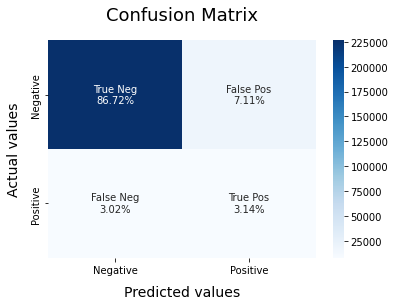

In [ ]:
confusion_matrix_for_data(test_y1, test_output1)